In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from scipy.misc import imread
import matplotlib.patches as patches
from torch.utils.data import DataLoader
from torch.optim import SGD, RMSprop, Adam
import cv2
from faster_rcnn.network import  clip_gradient
from faster_rcnn.faster_rcnn import FasterRCNN
from pycrayon import CrayonClient
import torch
from datetime import datetime



def collate_fn(batch):
    return batch

/data
/data/data/mscoco


In [3]:
import os
import torchvision.transforms as transforms
from faster_rcnn.utils.dataset import CocoData
from faster_rcnn.utils.data_generator import CocoGenerator
from faster_rcnn.utils.data_generator import Enqueuer


dataDir = './data/mscoco'
dataType = 'train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
pre_proposal_folder = './data/mscoco/coco_proposals/MCG/'
images_dir = os.path.join(dataDir,'images', dataType)
cap = CocoData(root = images_dir,
                        annFile = annFile)

loading annotations into memory...
Done (t=9.87s)
creating index...
index created!


In [ ]:
data_gen = CocoGenerator(data=cap)
queue = Enqueuer(generator=data_gen)
queue.start(max_queue_size=10, workers=2)
t = queue.get()


In [4]:
disp_interval = 10
log_interval = 10
save_interval = 10000

In [5]:
categories = ['__background__'] + [x['name'] for x in cap.coco.loadCats(cap.coco.getCatIds())]

In [6]:
net = FasterRCNN(categories, debug=False)
net.cuda()
net.train()

FasterRCNN(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(

In [8]:
param = filter(lambda x: x.requires_grad, net.parameters())

In [9]:
optimizer = SGD(param, lr=1e-4, momentum=0.9, weight_decay=0.0005)

In [11]:
preload_rois = np.load(open('./rois.np'))
preload_rois = torch.Tensor(preload_rois)
print preload_rois


   0.0000    0.0000  309.5071  799.0000  584.4722
   0.0000    0.0000  383.2783  757.0475  599.0000
   0.0000    0.0000  270.9279  715.2636  578.2669
                        ⋮                         
   0.0000    0.0000    0.0000  224.0748  189.8275
   0.0000  161.9529  179.7834  292.5122  482.4666
   0.0000    0.0000  529.2419   45.7396  599.0000
[torch.FloatTensor of size 2000x5]



In [12]:
def train(data_gen, optimizer, model, epoch):
#     exp_name = datetime.now().strftime('vgg16_%m-%d_%H-%M')
#     cc = CrayonClient(hostname="crayon", port=8889)
#     exp = cc.create_experiment(exp_name)
    model.train()
    train_loss = 0
    cross_entropy = 0
    loss_box = 0

    for step in range(1, epoch):
#         blobs = data_gen.next()
        blobs = cap[13499]

        im_data = blobs['tensor']
        im_info = blobs['im_info']
        gt_boxes = np.hstack([ blobs['boxes'] , blobs['gt_classes'][:, np.newaxis]])
        cls_prob, bbox_pred, rois = model(im_data, im_info, gt_boxes, rois=preload_rois)
        cls_data = cls_prob.data.cpu().numpy()
        max_class_idx = np.argmax(cls_data, axis=1)
        loss = model.loss
#         exp.add_scalar_value('loss', loss.data[0], step=step)
#         exp.add_scalar_value('cross_entropy loss', model.cross_entropy.data[0], step=step)
#         exp.add_scalar_value('loss_box loss', model.loss_box.data[0], step=step)
        cross_entropy += model.cross_entropy.data[0]
        loss_box += model.loss_box.data[0]
        train_loss += loss.data[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % disp_interval == 0:
            log_text = 'step %d, image: %s, loss: %.4f' % (
                step, blobs['im_name'], train_loss /(step))
            print(log_text)

            re_cnt = True

#         if step % log_interval == 0:
#             exp.add_scalar_value('cross_entropy', cross_entropy / step, step=step)
#             exp.add_scalar_value('loss_box', loss_box / step, step=step)
#             exp.add_scalar_value('train_loss', train_loss / step, step=step)
#         if step % save_interval == 0:
#             torch.save(model.state_dict(), 'model_at_step_%s.pkl' % step)

In [14]:
train(None, optimizer=optimizer, model=net, epoch=1200)

faster_rcnn/faster_rcnn.py:250: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cls_score = self.score_fc(x)


step 10, image: COCO_train2014_000000309241.jpg, loss: 0.0849
step 20, image: COCO_train2014_000000309241.jpg, loss: 0.0858
step 30, image: COCO_train2014_000000309241.jpg, loss: 0.0859
step 40, image: COCO_train2014_000000309241.jpg, loss: 0.0854
step 50, image: COCO_train2014_000000309241.jpg, loss: 0.0849
step 60, image: COCO_train2014_000000309241.jpg, loss: 0.0841
step 70, image: COCO_train2014_000000309241.jpg, loss: 0.0842
step 80, image: COCO_train2014_000000309241.jpg, loss: 0.0841
step 90, image: COCO_train2014_000000309241.jpg, loss: 0.0834
step 100, image: COCO_train2014_000000309241.jpg, loss: 0.0830
step 110, image: COCO_train2014_000000309241.jpg, loss: 0.0828
step 120, image: COCO_train2014_000000309241.jpg, loss: 0.0821
step 130, image: COCO_train2014_000000309241.jpg, loss: 0.0821
step 140, image: COCO_train2014_000000309241.jpg, loss: 0.0820
step 150, image: COCO_train2014_000000309241.jpg, loss: 0.0817
step 160, image: COCO_train2014_000000309241.jpg, loss: 0.0817
s

In [ ]:
torch.save(net.state_dict(), 'model.pkl')

In [ ]:
net.load_state_dict(torch.load('./model.pkl'))

In [15]:
blobs = cap[13499]
print blobs
im_path = os.path.join('/data/data/mscoco/images/train2014/', 'COCO_train2014_000000309241.jpg')

{'gt_classes': array([24, 24, 24], dtype=int32), 'tensor': 
( 0 , 0 ,.,.) = 
  0.0912  0.4166  0.5707  ...  -2.0152 -2.0837 -2.0152
  0.0912  0.0056  0.2111  ...  -1.9980 -2.0152 -1.9124
 -0.0116 -0.0629  0.1939  ...  -1.9295 -2.0152 -1.9809
           ...             ⋱             ...          
 -1.3644 -1.7925 -1.5699  ...  -1.8097 -1.7583 -1.7069
 -0.1657 -1.2103 -1.5357  ...  -1.8268 -1.7925 -1.7412
  1.3755 -0.0287 -1.1075  ...  -1.7583 -1.6042 -1.3987

( 0 , 1 ,.,.) = 
  1.0805  1.1856  1.2031  ...  -1.8782 -1.9132 -1.8431
  1.2556  0.9580  0.9930  ...  -1.8782 -1.8957 -1.7731
  1.0980  0.8354  0.9405  ...  -1.8256 -1.9132 -1.8782
           ...             ⋱             ...          
 -0.8627 -1.4405 -1.5630  ...  -1.6681 -1.5980 -1.5455
  0.5728 -0.5476 -1.2129  ...  -1.6856 -1.6331 -1.5805
  1.3957  0.3978 -0.6527  ...  -1.7381 -1.5630 -1.3354

( 0 , 2 ,.,.) = 
  2.0125  2.2043  2.2043  ...  -1.6999 -1.7522 -1.6824
  2.3437  1.9080  1.8557  ...  -1.6999 -1.7173 -1.5953
  2.186

In [33]:
pred_boxes, scores, classes, rois = net.detect(im_path, rois=preload_rois, thr=0.3)

net.classes[24]

torch.Size([2000, 5])
[[ 600.    800.      1.25]]
torch.Size([2000, 5])
(2000,)
[ 0.99352348  0.99557108  0.99482948  0.99147183  0.98038793  0.99589491
  0.99617285  0.99493742  0.99658245  0.99381012  0.99327278  0.99378866
  0.99273491  0.52307117  0.98550946  0.98710144  0.99251771  0.99085534
  0.99418408  0.58308423  0.60751975  0.70292771  0.99474585  0.99447364
  0.99598819  0.99454725  0.99585021  0.99882251  0.99315095  0.99442095
  0.99496883  0.99465781  0.99474454] [24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24]
[  12   16   51   56   58  100  116  146  330  459  494  614  631  654  830
  833  851  857  923 1000 1048 1084 1087 1277 1280 1369 1394 1403 1586 1654
 1757 1868 1966]
(33, 324)
(33, 4)
[ 600.  800.]


faster_rcnn/faster_rcnn.py:251: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cls_prob = F.softmax(cls_score)


u'giraffe'

In [34]:
def imshow(inp, gt_boxes=[], predict_boxes = []):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig,ax = plt.subplots(1, figsize=(20, 10))

    ax.imshow(inp)
    for i, box in enumerate(gt_boxes):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=2,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        
    for i, box in enumerate(predict_boxes):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=1,edgecolor='g',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.pause(0.001)  # pause a bit so that plots are updated


In [35]:
x = preload_rois.numpy()[:,1:]

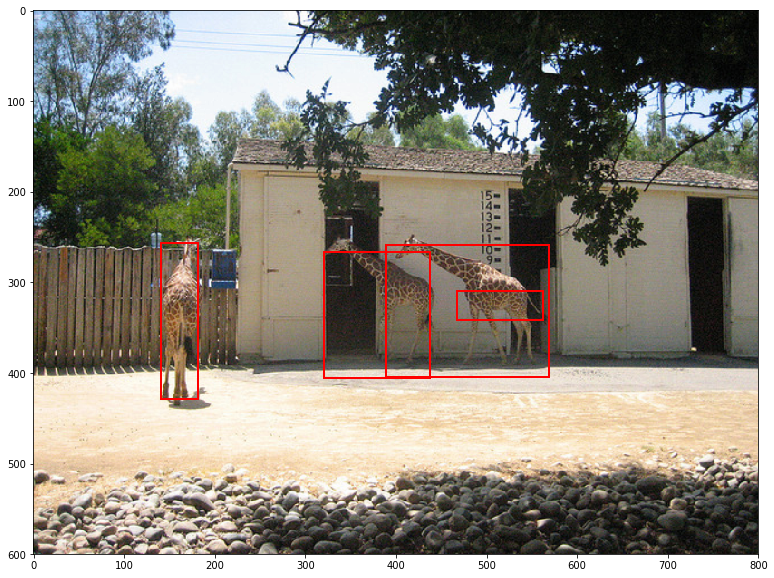

In [36]:
imshow(blobs['tensor'][0],pred_boxes)